# Spam Text Classifier Using Scikit-Learn
By Imaad Junaidi

Dataset from <a href='https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection'>UCI Machine Learning Repository</a>

## Part 1 - What's the Problem?

Before we set out we first need to understand what our problem is and outline a plan to solve that problem. Our goal today is to create a spam text classifier. "What is a spam text?", you may ask. Well, according to Merriam-Webster, spam is <b>any unsolicited, usually commmerical messages sent to a large number of recipients</b>. You probably have heard of it in the context of emails, but it can apply to any form of digital communication! Now that you know what spam is, it should be easy to understand what ham (messages that you want) is. The problem should be pretty clear now, so it's time to outline a plan. We'll be using the checklist by Aurélien Géron, author of <i>"Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow" (O'Reilly, 2019, 2nd edition)</i>.

1. Frame the problem and look at the big picture (we've already done that)
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms
5. Explore many different models and shortlist the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor, and maintain your system

Let's get started!

## Part 2 - Getting Setup and Getting Our Data

First things first is to get all the required libraries that we'll need for this project.

In [1]:
# Common imports
import pandas as pd
import numpy as np

# Used for plotting
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Part of our data preparation
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# We use these for our transformers
import re
import urlextract
import nltk
from nltk.corpus import stopwords # if not downloaded run >> nltk.download('stopwords')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

# Model Selection and Performance Metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve

# Saving Model
import joblib

That was a lot of imports, but now we're ready to start writing some code.

In [2]:
# Loading and viewing the data
text_df = pd.read_csv('ham_spam_texts.csv')
text_df.head()

,Label,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


So far so good! Now we have some data to look at. You can see that we have two columns, 'Label' and 'Content'. 'Label' just tells us whether a text is ham or spam, and 'Content' gives us the actual text message. Let's find out more about this dataset.

In [3]:
# Getting overall shape of the dataset as well as the distribution of ham and spam data
rows, columns = text_df.shape
label_vals = text_df['Label'].value_counts()

print('Rows: {}\nColumns: {}\n'.format(rows, columns))
print(label_vals, '\n')
print(text_df.isna().sum())

Rows: 5572
Columns: 2

ham     4825
spam     747
Name: Label, dtype: int64 

Label      0
Content    0
dtype: int64


Ok great, now we know how many values we have and that none of them are null! The data seems to be really unbalanced though. Over 86% of that data is ham data! Let's keep this in mind for later. For now, we should start exploring this data.

## Part 3 - Exploring and Visualizing the Data

The first thing I want to do is split up the ham and spam data so that we can see if there's differences between them we can observe.

In [4]:
ham_texts = text_df.loc[text_df['Label'] == 'ham']
spam_texts = text_df.loc[text_df['Label'] == 'spam']

Let's make sure that we split up these datasets correctly.

In [5]:
ham_texts.head()

,Label,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


In [6]:
spam_texts.head()

,Label,Content
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


Looks good to me! Since we're dealing with text messages, I'd like to see if there are any words that are common to either ham or spam texts. To do this we are going to use wordclouds.

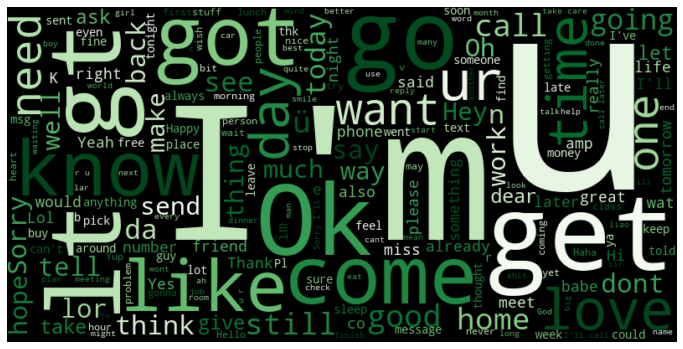

In [7]:
# Ham wordcloud
ham_wordcloud = WordCloud(width=800, height=400, stopwords=stopwords.words('english'), colormap='Greens').generate(' '.join(ham_texts['Content'].to_numpy().tolist()))
plt.figure(figsize=(12,10))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

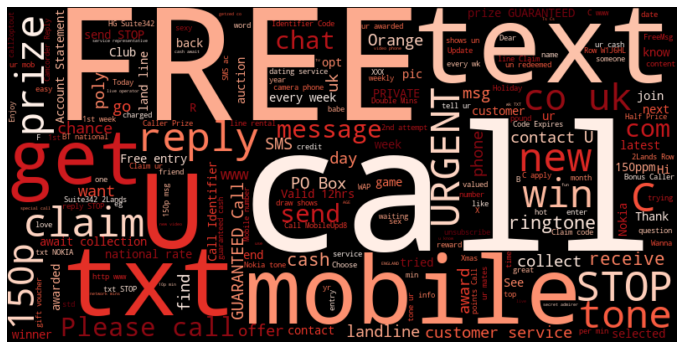

In [8]:
# Spam wordcloud
spam_wordcloud = WordCloud(width=800, height=400, stopwords=stopwords.words('english'), colormap='Reds').generate(' '.join(spam_texts['Content'].to_numpy().tolist()))
plt.figure(figsize=(12,10))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Pretty! So now we know some common words that show up in both groups. Are these words similar to what you would expect? Seeing these words early on might help you understand the process behind what your machine is doing to classify texts as ham or spam. For example, notice how 'www' and 'com' show up in the wordcloud for spam texts. Perhaps a link is a strong indicator that a text is spam? Try to find other patterns that may exist using this wordcloud, it can help when we preprocess our data later on. 

Moving on, refer back to earlier when we mentioned that there was an imbalance in the dataset. Let's visualize that.

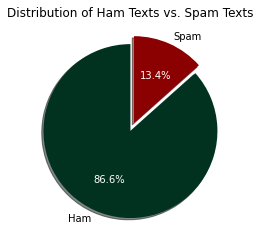

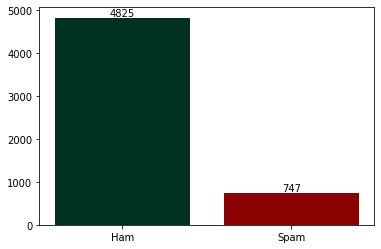

In [9]:
plt.style.use('fast')

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

patches, texts, autotexts = ax1.pie([len(ham_texts), len(spam_texts)], labels=['Ham', 'Spam'], colors=['#013220', '#8b0000'], explode=(0,0.1), autopct='%1.1f%%', shadow=True, startangle=90)
fig1.set_facecolor('white')
[autotext.set_color('white') for autotext in autotexts]

bar = ax2.bar(['Ham', 'Spam'], height=[len(ham_texts), len(spam_texts)], color=['#013220', '#8b0000'])
ax2.bar_label(bar)

ax1.set_title('Distribution of Ham Texts vs. Spam Texts')

plt.show()

Ok, this is definitely a problem. If we trained a model on this dataset, the results would probably be poor. The model would probably overgeneralize to the ham data and we wouldn't get a very good classifier. Maybe there's a lot of duplicate ham texts, so let's get rid of those (as well as dropping duplicates in the spam dating for consistency).

In [10]:
ham_texts = ham_texts.drop_duplicates()
spam_texts = spam_texts.drop_duplicates()

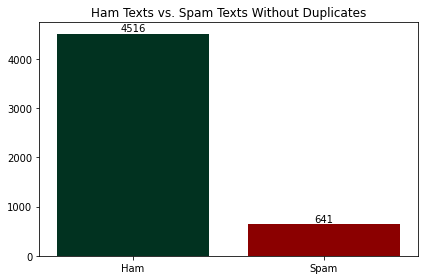

In [11]:
fig, ax = plt.subplots()

bar = ax.bar(['Ham', 'Spam'], height=[len(ham_texts), len(spam_texts)], color=['#013220', '#8b0000'])
ax.bar_label(bar)

ax.set_title('Ham Texts vs. Spam Texts Without Duplicates')

fig.tight_layout()
plt.show()

Well that cleared out some data, but it didn't really fix the issue. The way we're going to fix this is by resampling. This is done by taking the data that is overrepresented and randomly sampling <i>n</i> values out of it. So in the case of the ham data, we want to randomly pick 641 values from the hame texts. This will make it so it's balanced with the spam data, and will still be a good representation since it's randomly sampled.

In [12]:
ham_texts = resample(ham_texts, replace=True, n_samples=len(spam_texts), random_state=10)

Let's take a look at the distribution once more.

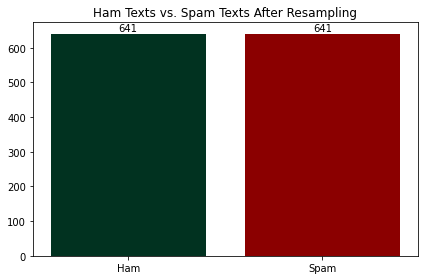

In [13]:
fig, ax = plt.subplots()

bar = ax.bar(['Ham', 'Spam'], height=[len(ham_texts), len(spam_texts)], color=['#013220', '#8b0000'])
ax.bar_label(bar)

ax.set_title('Ham Texts vs. Spam Texts After Resampling')

fig.tight_layout()
plt.show()

Look at that! It's perfect! I'd say that takes care of our data exploration let's move on to preparing this data for our model!

## Part 4 - Preparing the Data for Training

Before we start with our preprocessing, we need to split our data into training and testing sets.

In [14]:
# Combining ham and spam data
balanced_texts_df = pd.concat([ham_texts, spam_texts]).reset_index(drop=True)

# Separating text messages from their labels
X = balanced_texts_df['Content']
y = balanced_texts_df['Label']

# Cast 0 to ham data and 1 to spam data for training purposes
y = y.apply(lambda x: 0 if x == 'ham' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Now that those datasets are made, we'll make sure not to take a look at the test sets and only work with the training data. Our next step is to transform our data.

In [15]:
class TextToCleanSentenceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, to_lower=True, replace_URL=True, replace_num=True, replace_punc=True, stem_words=True, stemmer=nltk.PorterStemmer(), url_extractor=urlextract.URLExtract(), remove_stop_words=True):
        self.to_lower = to_lower
        self.replace_URL = replace_URL
        self.url_extractor = url_extractor
        self.replace_punc = replace_punc
        self.replace_num = replace_num
        self.stem_words = stem_words
        self.stemmer = stemmer
        self.remove_stop_words = remove_stop_words
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            if self.to_lower:
                text = text.lower()
            if self.replace_URL and self.url_extractor is not None:
                for url in self.url_extractor.find_urls(text):
                    text = text.replace(url, ' url ')
            if self.replace_punc:
                text = re.sub(r'[^a-zA-Z\d\s]+', '', text)
            if self.replace_num:
                text = re.sub(r'\d+', ' number ', text)
            words = text.split()
            if self.stem_words and self.stemmer is not None:
                stemmed_words = []
                for word in words:
                    if self.remove_stop_words:
                        if word not in stopwords.words('english'):
                            stemmed_word = self.stemmer.stem(word)
                            stemmed_words.append(stemmed_word)
                    else:
                        stemmed_word = self.stemmer.stem(word)
                        stemmed_words.append(stemmed_word)
                words = stemmed_words
            text_sentence = ' '.join(words)
            X_transformed.append(text_sentence)
        return np.array(X_transformed)

<b>Woah, woah, woah!</b> What just happened?! Let's hit the brakes, this was a lot of code.

#### Taking Apart the TextToCleanSentenceTransformer

There's obviously a lot going on in this block of code, but we are going to go through all of it. Firstly, this class that we have made is our own custom transformer. For more info on how to create your own custom transformers and what BaseEstimator and TransformerMixin are, refer to Chapter 2 of <i>"Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow" (O'Reilly, 2019, 2nd edition)</i> by Aurélien Géron. We are going to walk through the 5 transformation that are happening in this code.
1. Lower Case Transformation
2. URL Replacement
3. Punctuation Removal
4. Number Replacement
5. Word Stemming and Stop Word Removal

##### Lower Case Transformation
This step is important so that later on, when we create a vector of word counts, we don't count one word as two different words. What does this mean? Let's look at the sentence "The cat said hi to the dog". How many times does the word 'the' appear? That's easy, twice. But what if we were a computer. We'd look at the string 'the', loop through our sentence and return that the string 'the' appears once in the sentence. It would not count 'The' because that capital 'T' makes it think it's an entirely different word. Transforming everything to lowercase removes that issue.

##### URL Replacement
Recall back to earlier, when we made our wordcloud, we noted that links seemed to be pretty common in spam text messages. There could be a variety of links among a variety of messages though. And when we make a vector of word counts, we don't want each link to have a unique place in our vocabulary. We just want to know if a text message has a link! That's why we replace these links with the word 'url'. Let's take a closer look how we do this with the urlextract library.

In [16]:
# Instantiate a URL extractor
url_extractor = urlextract.URLExtract()

url_test_string = 'Hey! Check out this cool website I found http://spotifycollage.com theres also this other one, imaadjunaidi.com'

# Extractor returns a list of all URLs present in string
urls = url_extractor.find_urls(url_test_string)
print(urls)

['http://spotifycollage.com', 'imaadjunaidi.com']


As you can see, urlextract allows us to isolate URLs in a string and using this tool we can replace them as needed.

##### Punctuation Removal and Number Replacement
These steps are fairly straightforward. Punctuation and other non-alphanumeric characters should be removed as we are primarily focused on what words are present in the language. Using the same logic we applied to replacing the URLs is why we replace numbers with the string 'number'.

##### Word Stemming and Stop Word Removal
Stemming is the process of reducing a word to its stem. We'll see an example of what this looks like, but first let's talk about why we do it. It's actually quite similar to when we made everything lower case because we didn't want to repeat words. The difference being that with stemming, we don't want to repeat words that <i>mean</i> the same thing. For example the words 'admiration', 'admirable', 'admires', 'admired' all come from the word 'admire', so all these words mean roughly the same thing (to some degree). When we stem all these words they all become 'admir', so when we make a vector with our word counts, they all get counted the same. The NLTK library enables us to do stemming quickly and easily.

In [17]:
stem_test_words = ['consult', 'consultant', 'consulting', 'consultantative', 'consultants', 'consulting', 'consults']

test_stemmer = nltk.PorterStemmer()

for word in stem_test_words:
    print(test_stemmer.stem(word))

consult
consult
consult
consult
consult
consult
consult


Stop words are words like 'the', 'a', 'an', 'so', or 'what'. They are common words that don't add much meaning to text that we analyze. We remove them so that our model trains on text that has actual significance in determining whether or not a text is ham or spam. We are using the stop words from the NLTK corpus.

In [18]:
# Stopwords for English language
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

That's how we make our transformer! You can try changing values of the boolean conditions later on to see how they affect what model works best, as well as good strong such a model would be. For now let's make sure our transformer works.

In [19]:
some_data = X_train[:5]
for text in some_data:
    print(text)

U have a secret admirer who is looking 2 make contact with U-find out who they R*reveal who thinks UR so special-call on 09058094599
Great News! Call FREEFONE 08006344447 to claim your guaranteed £1000 CASH or £2000 gift. Speak to a live operator NOW!
Ok... U enjoy ur shows...
Twinks, bears, scallies, skins and jocks are calling now. Don't miss the weekend's fun. Call 08712466669 at 10p/min. 2 stop texts call 08712460324(nat rate)
What u mean u almost done? Done wif sleeping? But i tot u going to take a nap.. Yup i send her liao so i'm picking her up at ard 4 smth lor..


In [20]:
some_data_transformed = TextToCleanSentenceTransformer().fit_transform(some_data)
print(some_data_transformed)

['u secret admir look number make contact ufind rreveal think ur specialcal number'
 'great news call freefon number claim guarante number cash number gift speak live oper'
 'ok u enjoy ur show'
 'twink bear scalli skin jock call dont miss weekend fun call number number pmin number stop text call number nat rate'
 'u mean u almost done done wif sleep tot u go take nap yup send liao im pick ard number smth lor']


It works just as we wanted it to! Next thing we have to do is transform these sentences into vectors. Which leads us too...

#### Word Vectorizer
Luckily for us Scikit-Learn has a built-in CountVectorizer we can use. Let's see what it does with our some_data_transformed list.

In [21]:
test_vectorizer = CountVectorizer()
some_data_vectorized = test_vectorizer.fit_transform(some_data_transformed)
some_data_vectorized
some_data_vectorized.toarray()

array([[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]], dtype=int64)

In [22]:
test_vectorizer.get_feature_names_out()

array(['admir', 'almost', 'ard', 'bear', 'call', 'cash', 'claim',
       'contact', 'done', 'dont', 'enjoy', 'freefon', 'fun', 'gift', 'go',
       'great', 'guarante', 'im', 'jock', 'liao', 'live', 'look', 'lor',
       'make', 'mean', 'miss', 'nap', 'nat', 'news', 'number', 'ok',
       'oper', 'pick', 'pmin', 'rate', 'rreveal', 'scalli', 'secret',
       'send', 'show', 'skin', 'sleep', 'smth', 'speak', 'specialcal',
       'stop', 'take', 'text', 'think', 'tot', 'twink', 'ufind', 'ur',
       'weekend', 'wif', 'yup'], dtype=object)

This is a bit confusing so let's walk through it. The vectorizes takes in the text that we input and creates a vocabulary. You'll notice all the words here come from our some_data_transformed list. It then goes through our list and counts each time a word from our vocabulary shows up in a message, and keeps that count at the same index the word has in the vectorizer's vocabulary. For example, admir is the first word in the vocabulary, and it shows up in the first sentence 1 time. That's why in the first list, there is a 1 in the first index. Another example would be that the word 'call' appears in the third sentence 3 times. So at index 4 in the third list, there is a 3. You'll find that the word call is also at index 4 in the vectorizer's vocabulary.

Now that we've set up our transformers we can put them together in a pipeline using Scikit-Learn's Pipeline class. For more information on pipelines refer to Chapter 2 of <i>"Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow" (O'Reilly, 2019, 2nd edition)</i> by Aurélien Géron or the Scikit-Learn documentation.

In [23]:
preprocess_pipeline = Pipeline([
    ('text_to_clean_sentence', TextToCleanSentenceTransformer()),
    ('count_vectorizer', CountVectorizer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

And with that we've finished preparing our data for our Machine Learning algorithms.

## Part 5 - Testing Out Some Models

There are so many classifiers that we can use for this problem, but some will work better than others. To see how well a classifier performs we'll rely on the accuracy, precision, recall, and $F_{1}$ scores. To help explain these first we'll look at confusion matrices. A confusion matrix tells us the number of times a classifier correctly or incorrectly classified data. They look like this:

\begin{bmatrix}
TP & FP\\
FN & TN
\end{bmatrix}

<b>TP</b> - True Positive, <b>FP</b> - False Positive, <b>FN</b> - False Negative, <b>TN</b> - True Negative

Positive in our case being classified as spam and negative being classified as ham. We'll use these conventions to help understand our scoring metrics.

- Accuracy: the number of correctly predicted data points out of all data points, $\frac{TP + TN}{TP + TN + FN + FP}$
- Precision: the quality of positive predictions made by a model, $\frac{TP}{TP + FP}$
- Recall: the ratio of positive instances that are correctly identified by the classifier, $\frac{TP}{TP + FN}$
- $F_{1}$: the harmonic mean of precision and recall, $\frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

We'll use these four metrics to determine which model works best for us. We'll also look at which of these metrics would be most important for our purposes. Also, the way that we will be testing out all the different classifiers is by using <b>cross-validation</b> (specifically K-fold). K-fold Cross-validation involves dividing our training set into <i>K</i> subsets, with the validation being repeated <i>K</i>. Each time, a single subset is held out as the validation set. The model is trained on the remaining data and tested on that validation set. Let's get started with our models!

#### SGDClassifier

In [24]:
sgd_clf = SGDClassifier(random_state=10)

y_train_pred_sgd = cross_val_predict(sgd_clf, X_train_transformed, y_train, cv=5) # K-fold cross validation with 5 folds

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_sgd)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_sgd)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_sgd)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_sgd)))

Accuracy: 94.44%
Precision: 95.28%
Recall: 93.62%
F1 Score: 94.44%


#### Decision Tree Classifier

In [25]:
tree_clf = DecisionTreeClassifier(random_state=10)

y_train_pred_tree = cross_val_predict(tree_clf, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_tree)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_tree)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_tree)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_tree)))

Accuracy: 92.29%
Precision: 93.98%
Recall: 90.52%
F1 Score: 92.22%


#### KNeighbors Classifier

In [26]:
neighbors_clf = KNeighborsClassifier(weights='uniform')

y_train_pred_neighbors = cross_val_predict(neighbors_clf, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_neighbors)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_neighbors)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_neighbors)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_neighbors)))

Accuracy: 90.63%
Precision: 95.86%
Recall: 85.11%
F1 Score: 90.16%


#### Support Vector Machine

In [27]:
svm_clf = svm.SVC(kernel='linear', random_state=10)

y_train_pred_svm = cross_val_predict(svm_clf, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_svm)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_svm)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_svm)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_svm)))

Accuracy: 94.34%
Precision: 96.55%
Recall: 92.07%
F1 Score: 94.26%


#### Logistic Regression

In [28]:
log_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=10)

y_train_pred_log = cross_val_predict(log_clf, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_log)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_log)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_log)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_log)))

Accuracy: 94.73%
Precision: 97.34%
Recall: 92.07%
F1 Score: 94.63%


#### Random Forest Classifier

In [29]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=10)

y_train_pred_forest = cross_val_predict(forest_clf, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_forest)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_forest)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_forest)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_forest)))

Accuracy: 94.93%
Precision: 97.16%
Recall: 92.65%
F1 Score: 94.85%


#### Bernoulli Naive Bayes

In [30]:
nb_clf = BernoulliNB()

y_train_pred_nb = cross_val_predict(nb_clf, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_nb)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_nb)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_nb)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_nb)))

Accuracy: 95.41%
Precision: 99.37%
Recall: 91.49%
F1 Score: 95.27%


That was a lot! But we now have our performance scores for a variety of classifiers, and there appears to be one stand out. The BernoulliNB classifer scored the best on accuracy and precision! However, it's recall score didn't beat out some others. Does that matter? Well, it depends on your preferences. High precision in our case means that fewer ham text messages get classified as spam text messages. High recall would mean more spam emails would get correctly classified as spam emails. In our case, I think higher precision is more important, because we don't want a person's real text messages from their friends or family being sent to spam. Also remember that there is a trade-off when it comes to having high precision or recall, refer to Chapter 3 of <i>"Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow" (O'Reilly, 2019, 2nd edition)</i> by Aurélien Géron to learn more about this trade-off. All that being said, this is not too much of a worry since the classifer still has a high recall with its high precision.

I'm still not totally sold though. The Logistic Regression classfier and the Random Forest classifier had some pretty strong scores as well. Let's use one other metric to compare these three finalists.

### ROC Curve and ROC AUC Score
The ROC (<i>receiver operating characteristic</i>) curve plots the recall against the FPR (<i>false positive rate</i>). The FPR is the ratio of negative data that is incorrectly classified as positive. The ROC AUC score is the value of the area under the ROC curve (hence AUC). A perfect classifier would have and ROC AUC equal to 1, while a random classifier would have an ROC AUC of 0.5. We want to get as close to 1 as we can. Let's compare the ROC curves of our three classifiers and see which one has the best ROC AUC score.

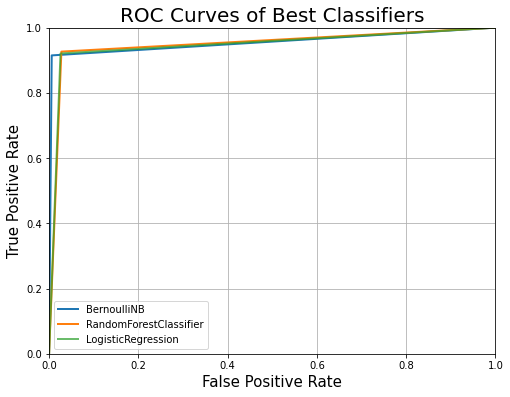

In [31]:
nb_fpr, nb_tpr, nb_threshold = roc_curve(y_train, y_train_pred_nb)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_train, y_train_pred_forest)
log_fpr, log_tpr, log_threshold = roc_curve(y_train, y_train_pred_log)

# plot_roc_curve function from Chapter 3 of "Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow" (O'Reilly, 2019, 2nd edition) by Aurélien Géron
def plot_roc_curve(fpr, tpr, label=None, alpha=1):
    plt.plot(fpr, tpr, linewidth=2, label=label, alpha=alpha)
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate', fontsize=15) 
    plt.ylabel('True Positive Rate', fontsize=15)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))       

plot_roc_curve(nb_fpr, nb_tpr, label='BernoulliNB')
plot_roc_curve(forest_fpr, forest_tpr, label='RandomForestClassifier')
plot_roc_curve(log_fpr, log_tpr, label='LogisticRegression', alpha=0.7)

plt.title('ROC Curves of Best Classifiers', fontsize=20)
plt.legend()
plt.show()

Interesting! Our three classifiers have ROC curves that are very close. Let's look at those ROC AUC scores now.

In [32]:
print('BernoulliNB AUC: {:.4f}'.format(roc_auc_score(y_train, y_train_pred_nb)))
print('RandomForest AUC: {:.4f}'.format(roc_auc_score(y_train, y_train_pred_forest)))
print('LogisticRegression AUC: {:.4f}'.format(roc_auc_score(y_train, y_train_pred_log)))

BernoulliNB AUC: 0.9545
RandomForest AUC: 0.9495
LogisticRegression AUC: 0.9476


So with all our analysis done it seems that the BernouilliNB classifier is the one we want to go with! It performed the best in most every metric, especially the ones that mattered. Now let's try fine-tuning our model to improve its scores.

## Part 6 - Fine-Tuning Our Model

We'll be performing a grid search on our model. Grid searching involves trying out combinations of different hyperparameters on our model and selecting the ones that make our model perform best on our training data.

In [33]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}

grid_search = GridSearchCV(nb_clf, param_grid, cv=5, scoring='precision', verbose=5, n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

y_train_pred_grid = cross_val_predict(grid_search.best_estimator_, X_train_transformed, y_train, cv=5)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred_grid)))
print('Precision: {:.2f}%'.format(100 * precision_score(y_train, y_train_pred_grid)))
print('Recall: {:.2f}%'.format(100 * recall_score(y_train, y_train_pred_grid)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_train, y_train_pred_grid)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy: 96.20%
Precision: 99.38%
Recall: 93.04%
F1 Score: 96.10%


That's a pretty great improvment! Accuracy, precision, and recall all went up! Let's look at what alpha value gave us these results.

In [34]:
grid_search.best_params_

{'alpha': 0.5}

If you were wondering, the default alpha value is 1, so performing a grid search did help us find a better model! Make note that you can choose what metric you want to score by (we chose precision). Play around with other metrics and maybe more options for hyperparameters and see where that leads you! I'm content with our current results, so now I'm ready to start...

## Part 7 - Showing Off Our Model

At long last, after all of our hard work, we have a working model! All that's left now is to let it predict values for our test set. Let's see how it does.

In [35]:
final_model = grid_search.best_estimator_

final_model.fit(X_train_transformed, y_train)

X_test_transformed = preprocess_pipeline.transform(X_test)

y_pred = final_model.predict(X_test_transformed)

print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}%'.format(100 * f1_score(y_test, y_pred)))

Accuracy: 96.89%
Precision: 100.00%
Recall: 93.55%
F1 Score: 96.67%


Wow! 100% precision, as well as high accuracy, recall, and F1! It's important to remember that the dataset we trained our model on was not too large (we removed quite a few instances of data after resampling), but nonetheless this is a good success! Especially for beginner's like us. Before we wrap up, let's quickly look at some visual representations of how our model did.

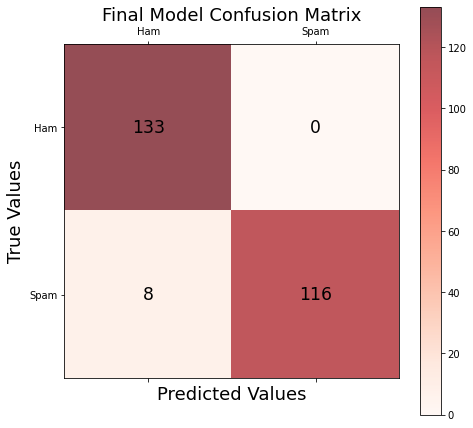

In [36]:
# Confusion Matrix Graphical Representation
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
cax = ax.matshow(conf_matrix, cmap='Reds', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')


ax.set_xticks([0, 1])
ax.set_xticklabels(['Ham', 'Spam'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Ham', 'Spam'])

fig.colorbar(cax)
 
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('True Values', fontsize=18)
plt.title('Final Model Confusion Matrix', fontsize=18)
plt.show()

Based on what we've already learned about confusion matrices, looking at this should just confirm our earlier findings. We can see that there was indeed 100% precision, as in the predicted spam column there's not a single ham text message. One thing to note about looking at confusion matrices like this, is that it's usually more helpful when working on multilabel problems. For example, say you were tackling the MNIST database, and you wanted to see what numbers your classifier was mixing up for each other (like mistaking a 7 for a 1 or vice versa). The intensity of the color on the confusion matrix can identify those types of correlations. That's a bit of a tangent though, let's look at one last plot before we finish up.

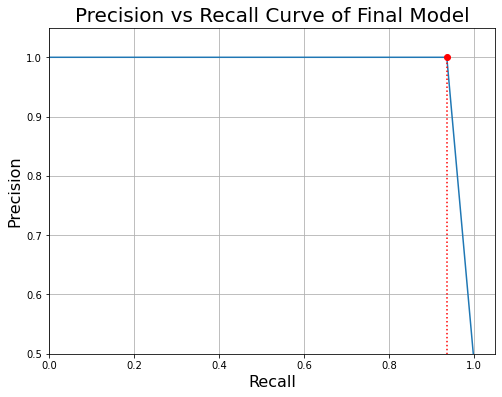

In [37]:
# Probability - Recall Curve of Final Model
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))

plt.plot(recalls, precisions)
plt.plot([recall_score(y_test, y_pred), recall_score(y_test, y_pred)], [0.4, 1], "r:")
plt.plot([recall_score(y_test, y_pred)], [1], "ro")

plt.axis([0, 1.05, 0.5, 1.05])
plt.grid(True)

plt.title('Precision vs Recall Curve of Final Model', fontsize=20)
plt.ylabel('Precision', fontsize=16)
plt.xlabel('Recall', fontsize=16)

plt.show()

The red dotted line represents the recall our model scored with, and as you can see that corresponds with a precision score of 1.0 (100%). PR curves are preferred over ROC curves whenever the positive class is rare, or when you care more about false positives than false negatives. The latter is true in our case (so we probably should have used PR curves when comparing our three best models earlier, but I wanted to introduce you to ROC curves). Where ROC curves are better if they push closer to the upper left, PR curves are better when they push closer to the upper right.

With that I can say that I'm happy with our model! We've presented it well and shown off what it can do. We can finally move on to our last step.

## Part 8 - What's Next?

The last step in our checklist is to launch, monitor, and maintain our model. I'm going to leave that to you. I'll show you how to save your model using Joblib.

In [38]:
# Dump saves the model into a file
joblib.dump(final_model, 'spam_classifier_model.pkl')

# Load loads the model from a file
final_model_loaded = joblib.load('spam_classifier_model.pkl')

To make sure the model was loaded correctly let's take a look at it.

In [39]:
final_model_loaded

BernoulliNB(alpha=0.5)

Looks good to me!

If you went through this whole project then you now have the ability to tackle more challenging machine learning projects! A great place to find new datasets would be <a href='http://kaggle.com'>kaggle.com</a>. Kaggle has a huge library of datasets and data science problems for you to mess around with. Also, if you're still a little bit confused about everything that we went through, that's ok! We didn't go through how each classifier works, or just a lot of what's going on in the background with Scikit-Learn. I'm still learning just as you are, so I can only explain so much. What's important is to ask questions. There are tons of resources out there to learn about machine learning, so make sure to use them. Also, we have in front of us a complete project that you can go through and tinker around with. Try using different classifiers, change some hyperparameters, try messing with some of the transformations we did. You can even try training a model on the full unbalanced data set and see where that leads you! Practice is really important when it comes to anything programming related and it really is the best way to learn. 

I hope this project was useful to you, and if you're reading this, <b>thank you for sticking with me all the way to the end!</b>

# Final Scores of Model
### - <b>Accuracy:</b> 96.89%
### - <b>Precision:</b> 100.00%
### - <b>Recall:</b> 93.55%
### - <b>F1 Score:</b> 96.67%